<a href="https://www.kaggle.com/code/kmljts/multiclass-pneumonia-detection?scriptVersionId=180660605" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# import os
# for root, folders, filenames in os.walk('/kaggle/input'):
#     print(root, folders)

In [2]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

from torchvision import datasets, transforms, models
from torchmetrics import ConfusionMatrix, AUROC
from mlxtend.plotting import plot_confusion_matrix

import os
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import pandas as pd
import random

from tqdm.auto import tqdm

In [3]:
input_dir = '/kaggle/input'
dataset_path = os.path.join(input_dir, 'pneumonia-multiclass/chest_xray')

output_dir = '/kaggle/working'
model_save_path = os.path.join(output_dir, 'models')
result_save_path = os.path.join(output_dir, 'results')
plot_save_path = os.path.join(output_dir, 'plots')

os.makedirs(model_save_path, exist_ok=True)
os.makedirs(result_save_path, exist_ok=True)
os.makedirs(plot_save_path, exist_ok=True)

dataset_path, model_save_path, result_save_path, plot_save_path

('/kaggle/input/pneumonia-multiclass/chest_xray',
 '/kaggle/working/models',
 '/kaggle/working/results',
 '/kaggle/working/plots')

In [4]:
# import shutil
# shutil.rmtree(output_dir)

In [5]:
# sorted(os.listdir(model_save_path)), sorted(os.listdir(result_save_path)), sorted(os.listdir(plot_save_path))

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device

device(type='cuda')

In [7]:
BATCH_SIZE = 64
LR = 1e-6
EPOCHS = 50

ANALYZE_DATASET = False
USE_BEST_MODEL_YET = False
NORMALIZE = True

In [8]:
torch.cuda.empty_cache()

In [9]:
def current_datetime():
    cur_datetime = datetime.now() + timedelta(hours=5, minutes=30) # IST
    return cur_datetime.strftime("%Y-%m-%d_%H-%M-%S")

def unique_file_namer(model_name, n_epochs=EPOCHS, learning_rate=LR, batch_size=BATCH_SIZE):
    return f'{current_datetime()}_{model_name}_{n_epochs}_{learning_rate:.2e}_{batch_size}'

In [10]:
class UnNormalize:
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        return tensor.clamp(-1, 1) * self.std + self.mean
    
class Identity:
    def __call__(self, tensor):
        return tensor

img_to_tensor = transforms.Compose([
    transforms.Resize((448,) * 2),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]) if NORMALIZE else Identity()
])

tensor_to_img = transforms.Compose([
    UnNormalize(0.5, 0.5) if NORMALIZE else Identity(),
    transforms.ToPILImage(),
    transforms.Resize((448,) * 2)
])

In [11]:
def random_sample(dataset, classes):
    input, target = random.choice(dataset)

    image = tensor_to_img(input)
    display(image)
    print('Target:', classes[target])

def random_pred(dataset, model, classes):
    input, target = random.choice(dataset)

    input = input.to(device)
    image = tensor_to_img(input)
    display(image)

    model.eval()
    with torch.inference_mode():
        logits = model(input.unsqueeze(0)).squeeze()

    print(f'{"Raw Logits: ":30}{logits}') # raw logits
    probs = logits.softmax(0)
    print(f'{"Prediction Probabilities: ":30}{probs}') # prediction probabilities
    label = probs.argmax(0).item()
    print(f'{"Prediction Labels: ":30}{label}', end='\n\n') # prediction label
    
    print('Prediction:', classes[label])
    print('Target:', classes[target])

def dataset_analyzer(dataset, classes):
    freqs = [0] * len(classes)
    for X, y in dataset:
        freqs[y] += 1

    return {classes[i]: freqs[i] for i in range(len(classes))}

In [12]:
def harmonic_mean(a, b):
    if a + b == 0: return 0
    return 2 * a * b / (a + b)

def manage_nan(tensor):
    return tensor if not torch.isnan(tensor).item() else torch.tensor(0.0).to(device)

def confmat_to_accuracy(confmat): # micro
    num_classes = confmat.shape[0]

    correct_preds = 0
    for i in range(num_classes):
        correct_preds += confmat[i, i]
    all_preds = confmat.sum()

    acc = manage_nan(correct_preds / all_preds)

    return acc.item()

def confmat_to_precision(confmat): # macro
    num_classes = confmat.shape[0]

    if num_classes == 2:
        return manage_nan(confmat[1, 1] / confmat[:, 1].sum()).item()

    prec = 0
    for i in range(num_classes):
        prec += manage_nan(confmat[i, i] / confmat[:, i].sum())
    prec /= num_classes

    return prec.item()

def confmat_to_recall(confmat): # macro
    num_classes = confmat.shape[0]

    if num_classes == 2:
        return manage_nan(confmat[1, 1] / confmat[1].sum()).item()

    rec = 0
    for i in range(num_classes):
        rec += manage_nan(confmat[i, i] / confmat[i].sum())
    rec /= num_classes

    return rec.item()

def confmat_to_f1score(confmat): # macro
    num_classes = confmat.shape[0]

    if num_classes == 2:
        return harmonic_mean(confmat_to_precision(confmat), confmat_to_recall(confmat))

    f1 = 0
    for i in range(num_classes):
        prec = manage_nan(confmat[i, i] / confmat[:, i].sum())
        rec = manage_nan(confmat[i, i] / confmat[i].sum())

        f1 += harmonic_mean(prec, rec)
    f1 /= num_classes

    return f1.item()

In [13]:
dataset = datasets.ImageFolder(dataset_path, transform=img_to_tensor)

len(dataset), random.choice(dataset)

(5856,
 (tensor([[[ 0.4196,  0.3647,  0.3490,  ...,  0.3804,  0.4353,  0.4431],
           [ 0.4118,  0.3725,  0.3412,  ...,  0.3647,  0.3804,  0.4118],
           [ 0.4039,  0.3804,  0.3412,  ...,  0.3412,  0.3490,  0.3882],
           ...,
           [-0.7961, -0.7961, -0.7961,  ..., -0.7098, -0.7020, -0.6941],
           [-0.7961, -0.7961, -0.7961,  ..., -0.7098, -0.7020, -0.7020],
           [-0.7961, -0.7961, -0.7961,  ..., -0.7176, -0.7098, -0.7020]],
  
          [[ 0.4196,  0.3647,  0.3490,  ...,  0.3804,  0.4353,  0.4431],
           [ 0.4118,  0.3725,  0.3412,  ...,  0.3647,  0.3804,  0.4118],
           [ 0.4039,  0.3804,  0.3412,  ...,  0.3412,  0.3490,  0.3882],
           ...,
           [-0.7961, -0.7961, -0.7961,  ..., -0.7098, -0.7020, -0.6941],
           [-0.7961, -0.7961, -0.7961,  ..., -0.7098, -0.7020, -0.7020],
           [-0.7961, -0.7961, -0.7961,  ..., -0.7176, -0.7098, -0.7020]],
  
          [[ 0.4196,  0.3647,  0.3490,  ...,  0.3804,  0.4353,  0.4431],
    

In [14]:
dataset.classes, dataset.class_to_idx

(['NORMAL', 'PNEUMONIA_BACTERIAL', 'PNEUMONIA_VIRAL'],
 {'NORMAL': 0, 'PNEUMONIA_BACTERIAL': 1, 'PNEUMONIA_VIRAL': 2})

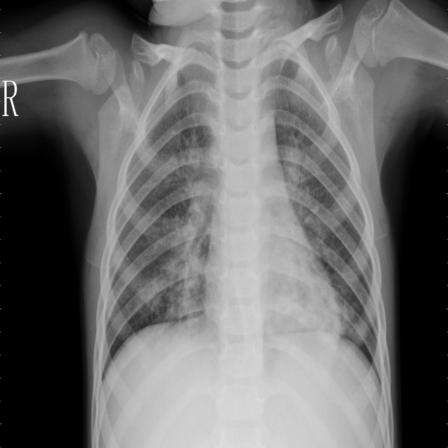

Target: PNEUMONIA_VIRAL


In [15]:
random_sample(dataset, classes=dataset.classes)

In [16]:
length = len(dataset)
split_ratio = (0.7, 0.1, 0.2)
train_size = int(length * split_ratio[0])
val_size = int(length * split_ratio[1])
test_size = length - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

len(train_dataset), len(val_dataset), len(test_dataset)

(4099, 585, 1172)

In [17]:
if ANALYZE_DATASET:
    train_dataset_info = dataset_analyzer(train_dataset, classes=dataset.classes)
    val_dataset_info = dataset_analyzer(val_dataset, classes=dataset.classes)
    test_dataset_info = dataset_analyzer(test_dataset, classes=dataset.classes)

    df = pd.DataFrame([train_dataset_info, val_dataset_info, test_dataset_info], index=['Train', 'Validation', 'Test'])
    df_splitwise_perc = df.copy()
    df.loc['Total'] = df.sum()
    df_classwise_perc = df.copy()
    display(df)

    df_classwise_perc.loc['Train Class-wise %'] = df_classwise_perc.loc['Train'] / df_classwise_perc.loc['Train'].sum()
    df_classwise_perc.loc['Validation Class-wise %'] = df_classwise_perc.loc['Validation'] / df_classwise_perc.loc['Validation'].sum()
    df_classwise_perc.loc['Test Class-wise %'] = df_classwise_perc.loc['Test'] / df_classwise_perc.loc['Test'].sum()
    df_classwise_perc.loc['Total Class-wise %'] = df_classwise_perc.loc['Total'] / df_classwise_perc.loc['Total'].sum()
    df_classwise_perc = df_classwise_perc.drop(['Train', 'Validation', 'Test', 'Total'])
    display(df_classwise_perc)

    df_splitwise_perc['NORMAL Split-wise %'] = df_splitwise_perc['NORMAL'] / df_splitwise_perc['NORMAL'].sum()
    df_splitwise_perc['PNEUMONIA_BACTERIAL Split-wise %'] = df_splitwise_perc['PNEUMONIA_BACTERIAL'] / df_splitwise_perc['PNEUMONIA_BACTERIAL'].sum()
    df_splitwise_perc['PNEUMONIA_VIRAL Split-wise %'] = df_splitwise_perc['PNEUMONIA_VIRAL'] / df_splitwise_perc['PNEUMONIA_VIRAL'].sum()
    df_splitwise_perc = df_splitwise_perc.drop(['NORMAL', 'PNEUMONIA_BACTERIAL', 'PNEUMONIA_VIRAL'], axis=1)
    display(df_splitwise_perc)

In [18]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

len(train_dataloader), len(val_dataloader), len(test_dataloader)

(65, 10, 19)

In [19]:
n_samples = torch.tensor([1583, 2780, 1493]).to(device)

n_samples

tensor([1583, 2780, 1493], device='cuda:0')

In [20]:
class_weights = n_samples.sum() / n_samples

class_weights

tensor([3.6993, 2.1065, 3.9223], device='cuda:0')

In [21]:
class PneumoniaDetector(nn.Module):
    def __init__(self):
        super().__init__()

        self.resnet = models.resnet18(weights='DEFAULT')
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, 3) # in_features = 512

    def forward(self, x):
        return self.resnet(x)

In [22]:
model = PneumoniaDetector().to(device)

if USE_BEST_MODEL_YET:
    best_model_name = sorted(os.listdir(model_save_path))[-1]
    best_model_path = os.path.join(model_save_path, best_model_name)
    print(best_model_path)
    model.load_state_dict(torch.load(best_model_path))

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 174MB/s]


In [23]:
model.eval()
with torch.inference_mode():
    pred = model(random.choice(train_dataset)[0].to(device).unsqueeze(0))
pred

tensor([[ 0.1166, -0.1360, -0.5276]], device='cuda:0')

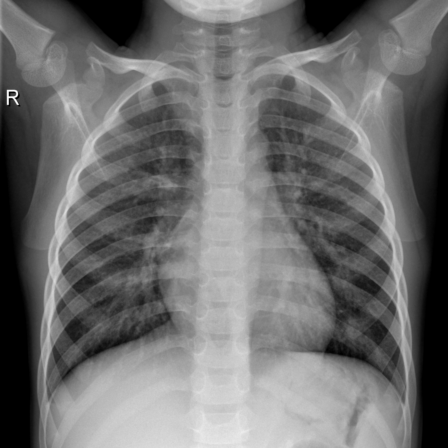

Raw Logits:                   tensor([-0.1273,  0.0577, -0.5401], device='cuda:0')
Prediction Probabilities:     tensor([0.3491, 0.4200, 0.2310], device='cuda:0')
Prediction Labels:            1

Prediction: PNEUMONIA_BACTERIAL
Target: NORMAL


In [24]:
random_pred(train_dataset, model, classes=dataset.classes)

In [25]:
# criterion = nn.CrossEntropyLoss(weight=class_weights)
criterion = nn.CrossEntropyLoss()
confmat_metric = ConfusionMatrix(task='multiclass', num_classes=3).to(device)
auroc_metric = AUROC(task='multiclass', num_classes=3).to(device)

optimizer = optim.Adam(model.parameters(), lr=LR)

In [26]:
train_losses = []
val_losses = []
accs = []
precs = []
recs = []
f1s = []
aurocs = []

In [27]:
train_losses, val_losses, accs, precs, recs, f1s, aurocs

([], [], [], [], [], [], [])

  0%|          | 0/10 [00:00<?, ?it/s]

Cross Entropy Loss: 1.0650
Accuracy: 48.55% | Precision: 44.72% | Recall: 45.98% | F1 Score: 39.26%
AUROC: 0.6244


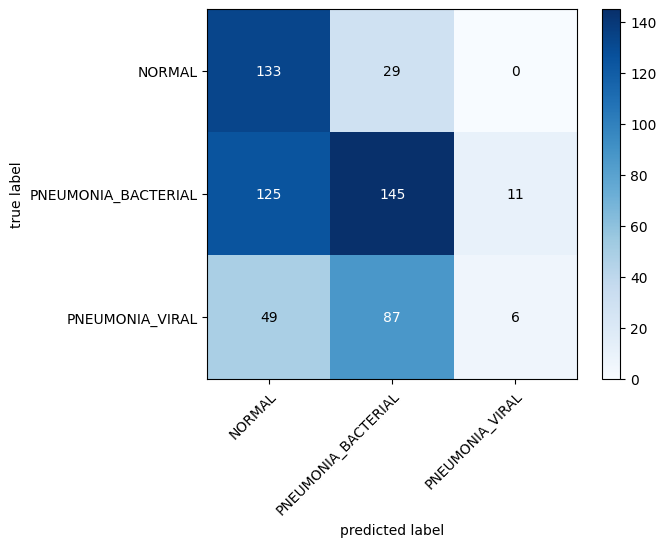

In [28]:
loss = 0
auroc = 0
master_confmat = torch.zeros(3, 3).to(device)

model.eval()
with torch.inference_mode():
    for X, y in tqdm(val_dataloader):
        X, y = X.to(device), y.to(device)
        logits = model(X)
        probs = logits.softmax(1)
        labels = probs.argmax(1)

        loss += criterion(logits, y).item()
        auroc += auroc_metric(probs, y).item()
        master_confmat += confmat_metric(labels, y)

loss /= len(val_dataloader)
auroc /= len(val_dataloader)
acc = confmat_to_accuracy(master_confmat)
prec = confmat_to_precision(master_confmat)
rec = confmat_to_recall(master_confmat)
f1 = confmat_to_f1score(master_confmat)

train_losses.append(loss)
val_losses.append(loss)
accs.append(acc)
precs.append(prec)
recs.append(rec)
f1s.append(f1)
aurocs.append(auroc)

print(f'Cross Entropy Loss: {loss:.4f}')
print(f'Accuracy: {acc * 100:.2f}% | Precision: {prec * 100:.2f}% | Recall: {rec * 100:.2f}% | F1 Score: {f1 * 100:.2f}%')
print(f'AUROC: {auroc:.4f}')

fig, ax = plot_confusion_matrix(
    conf_mat=master_confmat.cpu().numpy(),
    class_names=dataset.classes,
    colorbar=True
)

In [29]:
best_acc = acc
best_acc_epoch = 0

In [30]:
prev_size = len(train_losses)

for epoch in tqdm(range(EPOCHS)):
    train_loss = 0
    val_loss = 0
    auroc = 0
    master_confmat = torch.zeros(3, 3).to(device)

    model.train()
    for X, y in tqdm(train_dataloader):
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = criterion(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(val_dataloader):
            X, y = X.to(device), y.to(device)
            logits = model(X)
            probs = logits.softmax(1)
            labels = probs.argmax(1)

            val_loss += criterion(logits, y).item()
            auroc += auroc_metric(probs, y).item()
            master_confmat += confmat_metric(labels, y)

    train_loss /= len(train_dataloader)
    val_loss /= len(val_dataloader)
    auroc /= len(val_dataloader)
    acc = confmat_to_accuracy(master_confmat)
    prec = confmat_to_precision(master_confmat)
    rec = confmat_to_recall(master_confmat)
    f1 = confmat_to_f1score(master_confmat)

    print(f'Epoch: {epoch + prev_size}/{EPOCHS + prev_size - 1}')
    print(f'Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}')
    print(f'Accuracy: {acc * 100:.2f}% | Precision: {prec * 100:.2f}% | Recall: {rec * 100:.2f}% | F1 Score: {f1 * 100:.2f}%')
    print(f'AUROC: {auroc:.4f}')

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    accs.append(acc)
    precs.append(prec)
    recs.append(rec)
    f1s.append(f1)
    aurocs.append(auroc)

    if acc > best_acc:
        model_name = f'{unique_file_namer(model.__class__.__name__)}.pth'
        model_path = os.path.join(model_save_path, model_name)
        torch.save(model.state_dict(), model_path)
        print('>>> Model saved!')
        print(model_path)

        best_acc = acc
        best_acc_epoch = epoch + prev_size
    
    # reloading the best model yet every 5 epochs
    if epoch % 5 == 4:
        best_model_name = sorted(os.listdir(model_save_path))[-1]
        best_model_path = os.path.join(model_save_path, best_model_name)
        print('Reloaded:', best_model_path)

        model.load_state_dict(torch.load(best_model_path))

    print('\n' + '=' * 80 + '\n')

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1/50
Train Loss: 1.1148 | Val Loss: 1.0846
Accuracy: 30.94% | Precision: 36.01% | Recall: 35.59% | F1 Score: 19.09%
AUROC: 0.7852




  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 2/50
Train Loss: 0.9852 | Val Loss: 0.9130
Accuracy: 54.70% | Precision: 66.07% | Recall: 52.92% | F1 Score: 44.65%
AUROC: 0.8611
>>> Model saved!
/kaggle/working/models/2024-05-31_01-26-48_PneumoniaDetector_50_1.00e-06_64.pth




  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 3/50
Train Loss: 0.8900 | Val Loss: 0.8293
Accuracy: 64.79% | Precision: 69.08% | Recall: 63.05% | F1 Score: 59.05%
AUROC: 0.8833
>>> Model saved!
/kaggle/working/models/2024-05-31_01-28-45_PneumoniaDetector_50_1.00e-06_64.pth




  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 4/50
Train Loss: 0.8123 | Val Loss: 0.7812
Accuracy: 73.85% | Precision: 74.28% | Recall: 72.39% | F1 Score: 70.70%
AUROC: 0.8770
>>> Model saved!
/kaggle/working/models/2024-05-31_01-30-42_PneumoniaDetector_50_1.00e-06_64.pth




  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 5/50
Train Loss: 0.7501 | Val Loss: 0.6769
Accuracy: 74.19% | Precision: 73.62% | Recall: 73.23% | F1 Score: 71.61%
AUROC: 0.9084
>>> Model saved!
/kaggle/working/models/2024-05-31_01-32-38_PneumoniaDetector_50_1.00e-06_64.pth
Reloaded: /kaggle/working/models/2024-05-31_01-32-38_PneumoniaDetector_50_1.00e-06_64.pth




  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 6/50
Train Loss: 0.7152 | Val Loss: 0.6871
Accuracy: 75.56% | Precision: 74.62% | Recall: 74.65% | F1 Score: 73.30%
AUROC: 0.9055
>>> Model saved!
/kaggle/working/models/2024-05-31_01-34-35_PneumoniaDetector_50_1.00e-06_64.pth




  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 7/50
Train Loss: 0.6812 | Val Loss: 0.6433
Accuracy: 76.41% | Precision: 75.25% | Recall: 75.36% | F1 Score: 74.17%
AUROC: 0.9170
>>> Model saved!
/kaggle/working/models/2024-05-31_01-36-31_PneumoniaDetector_50_1.00e-06_64.pth




  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 8/50
Train Loss: 0.6526 | Val Loss: 0.6588
Accuracy: 76.75% | Precision: 75.51% | Recall: 75.68% | F1 Score: 74.44%
AUROC: 0.9140
>>> Model saved!
/kaggle/working/models/2024-05-31_01-38-28_PneumoniaDetector_50_1.00e-06_64.pth




  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 9/50
Train Loss: 0.6233 | Val Loss: 0.5718
Accuracy: 78.97% | Precision: 77.75% | Recall: 77.60% | F1 Score: 76.92%
AUROC: 0.9213
>>> Model saved!
/kaggle/working/models/2024-05-31_01-40-25_PneumoniaDetector_50_1.00e-06_64.pth




  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 10/50
Train Loss: 0.6094 | Val Loss: 0.5547
Accuracy: 78.63% | Precision: 77.03% | Recall: 77.25% | F1 Score: 76.43%
AUROC: 0.9207
Reloaded: /kaggle/working/models/2024-05-31_01-40-25_PneumoniaDetector_50_1.00e-06_64.pth




  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 11/50
Train Loss: 0.6140 | Val Loss: 0.5706
Accuracy: 78.46% | Precision: 77.10% | Recall: 76.78% | F1 Score: 75.96%
AUROC: 0.9186




  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 12/50
Train Loss: 0.5878 | Val Loss: 0.5651
Accuracy: 79.32% | Precision: 77.72% | Recall: 77.95% | F1 Score: 77.27%
AUROC: 0.8859
>>> Model saved!
/kaggle/working/models/2024-05-31_01-46-15_PneumoniaDetector_50_1.00e-06_64.pth




/opt/conda/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 13/50
Train Loss: 0.5770 | Val Loss: 0.5526
Accuracy: 79.49% | Precision: 77.79% | Recall: 78.65% | F1 Score: 77.76%
AUROC: 0.9275
>>> Model saved!
/kaggle/working/models/2024-05-31_01-48-19_PneumoniaDetector_50_1.00e-06_64.pth




  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 14/50
Train Loss: 0.5527 | Val Loss: 0.5457
Accuracy: 80.17% | Precision: 78.62% | Recall: 78.66% | F1 Score: 78.15%
AUROC: 0.9120
>>> Model saved!
/kaggle/working/models/2024-05-31_01-50-17_PneumoniaDetector_50_1.00e-06_64.pth




  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 15/50
Train Loss: 0.5506 | Val Loss: 0.5343
Accuracy: 80.34% | Precision: 78.84% | Recall: 78.81% | F1 Score: 78.43%
AUROC: 0.9285
>>> Model saved!
/kaggle/working/models/2024-05-31_01-52-14_PneumoniaDetector_50_1.00e-06_64.pth
Reloaded: /kaggle/working/models/2024-05-31_01-52-14_PneumoniaDetector_50_1.00e-06_64.pth




  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 16/50
Train Loss: 0.5421 | Val Loss: 0.5831
Accuracy: 80.85% | Precision: 79.22% | Recall: 79.83% | F1 Score: 79.20%
AUROC: 0.9207
>>> Model saved!
/kaggle/working/models/2024-05-31_01-54-11_PneumoniaDetector_50_1.00e-06_64.pth




  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 17/50
Train Loss: 0.5168 | Val Loss: 0.4722
Accuracy: 81.71% | Precision: 80.78% | Recall: 79.61% | F1 Score: 79.83%
AUROC: 0.9346
>>> Model saved!
/kaggle/working/models/2024-05-31_01-56-08_PneumoniaDetector_50_1.00e-06_64.pth




  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 18/50
Train Loss: 0.5046 | Val Loss: 0.4914
Accuracy: 82.22% | Precision: 80.90% | Recall: 80.81% | F1 Score: 80.65%
AUROC: 0.9339
>>> Model saved!
/kaggle/working/models/2024-05-31_01-58-05_PneumoniaDetector_50_1.00e-06_64.pth




  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 19/50
Train Loss: 0.4989 | Val Loss: 0.4670
Accuracy: 81.88% | Precision: 80.84% | Recall: 80.20% | F1 Score: 80.33%
AUROC: 0.9346




  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 20/50
Train Loss: 0.4933 | Val Loss: 0.4916
Accuracy: 82.05% | Precision: 81.15% | Recall: 80.23% | F1 Score: 80.48%
AUROC: 0.9297
Reloaded: /kaggle/working/models/2024-05-31_01-58-05_PneumoniaDetector_50_1.00e-06_64.pth




  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 21/50
Train Loss: 0.5013 | Val Loss: 0.5166
Accuracy: 81.71% | Precision: 80.45% | Recall: 79.99% | F1 Score: 79.90%
AUROC: 0.9075




  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 22/50
Train Loss: 0.4978 | Val Loss: 0.4934
Accuracy: 81.71% | Precision: 80.20% | Recall: 80.69% | F1 Score: 80.27%
AUROC: 0.9285




  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 23/50
Train Loss: 0.4878 | Val Loss: 0.4858
Accuracy: 81.71% | Precision: 80.29% | Recall: 80.22% | F1 Score: 80.00%
AUROC: 0.8998




  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 24/50
Train Loss: 0.4721 | Val Loss: 0.4406
Accuracy: 81.71% | Precision: 80.80% | Recall: 79.82% | F1 Score: 80.14%
AUROC: 0.9357




  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 25/50
Train Loss: 0.4670 | Val Loss: 0.4861
Accuracy: 82.74% | Precision: 81.51% | Recall: 81.40% | F1 Score: 81.29%
AUROC: 0.9244
>>> Model saved!
/kaggle/working/models/2024-05-31_02-11-46_PneumoniaDetector_50_1.00e-06_64.pth
Reloaded: /kaggle/working/models/2024-05-31_02-11-46_PneumoniaDetector_50_1.00e-06_64.pth




  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 26/50
Train Loss: 0.4651 | Val Loss: 0.4650
Accuracy: 82.91% | Precision: 81.65% | Recall: 81.75% | F1 Score: 81.57%
AUROC: 0.9307
>>> Model saved!
/kaggle/working/models/2024-05-31_02-13-44_PneumoniaDetector_50_1.00e-06_64.pth




  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 27/50
Train Loss: 0.4534 | Val Loss: 0.4507
Accuracy: 82.22% | Precision: 81.16% | Recall: 80.58% | F1 Score: 80.74%
AUROC: 0.9353




  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 28/50
Train Loss: 0.4472 | Val Loss: 0.4625
Accuracy: 82.39% | Precision: 81.50% | Recall: 80.52% | F1 Score: 80.77%
AUROC: 0.9266




  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 29/50
Train Loss: 0.4339 | Val Loss: 0.4278
Accuracy: 82.56% | Precision: 81.42% | Recall: 81.48% | F1 Score: 81.40%
AUROC: 0.9374




  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 30/50
Train Loss: 0.4273 | Val Loss: 0.4598
Accuracy: 82.22% | Precision: 81.05% | Recall: 81.04% | F1 Score: 81.00%
AUROC: 0.9197
Reloaded: /kaggle/working/models/2024-05-31_02-13-44_PneumoniaDetector_50_1.00e-06_64.pth




  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 31/50
Train Loss: 0.4663 | Val Loss: 0.4673
Accuracy: 82.39% | Precision: 81.26% | Recall: 80.84% | F1 Score: 80.85%
AUROC: 0.9290




  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 32/50
Train Loss: 0.4396 | Val Loss: 0.4572
Accuracy: 82.22% | Precision: 81.07% | Recall: 80.93% | F1 Score: 80.94%
AUROC: 0.9113




  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 33/50
Train Loss: 0.4433 | Val Loss: 0.4565
Accuracy: 83.08% | Precision: 82.05% | Recall: 81.72% | F1 Score: 81.80%
AUROC: 0.9024
>>> Model saved!
/kaggle/working/models/2024-05-31_02-27-26_PneumoniaDetector_50_1.00e-06_64.pth




  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 34/50
Train Loss: 0.4469 | Val Loss: 0.4548
Accuracy: 82.91% | Precision: 81.92% | Recall: 81.46% | F1 Score: 81.56%
AUROC: 0.9345




  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 35/50
Train Loss: 0.4214 | Val Loss: 0.4277
Accuracy: 82.39% | Precision: 81.25% | Recall: 81.25% | F1 Score: 81.19%
AUROC: 0.9406
Reloaded: /kaggle/working/models/2024-05-31_02-27-26_PneumoniaDetector_50_1.00e-06_64.pth




  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 36/50
Train Loss: 0.4434 | Val Loss: 0.4355
Accuracy: 82.74% | Precision: 81.65% | Recall: 81.40% | F1 Score: 81.45%
AUROC: 0.9063




  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 37/50
Train Loss: 0.4320 | Val Loss: 0.4207
Accuracy: 82.39% | Precision: 81.23% | Recall: 81.37% | F1 Score: 81.25%
AUROC: 0.9399




  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 38/50
Train Loss: 0.4133 | Val Loss: 0.4362
Accuracy: 82.74% | Precision: 81.62% | Recall: 81.60% | F1 Score: 81.56%
AUROC: 0.9356




  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 39/50
Train Loss: 0.4095 | Val Loss: 0.4278
Accuracy: 82.74% | Precision: 81.66% | Recall: 81.31% | F1 Score: 81.44%
AUROC: 0.9388




  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 40/50
Train Loss: 0.4087 | Val Loss: 0.4195
Accuracy: 82.39% | Precision: 81.15% | Recall: 81.45% | F1 Score: 81.25%
AUROC: 0.9386
Reloaded: /kaggle/working/models/2024-05-31_02-27-26_PneumoniaDetector_50_1.00e-06_64.pth




  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 41/50
Train Loss: 0.4426 | Val Loss: 0.4511
Accuracy: 82.91% | Precision: 81.85% | Recall: 81.61% | F1 Score: 81.65%
AUROC: 0.9293




  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 42/50
Train Loss: 0.4325 | Val Loss: 0.4649
Accuracy: 82.74% | Precision: 81.37% | Recall: 81.98% | F1 Score: 81.61%
AUROC: 0.9330




  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 43/50
Train Loss: 0.4150 | Val Loss: 0.4395
Accuracy: 82.56% | Precision: 81.66% | Recall: 80.99% | F1 Score: 81.25%
AUROC: 0.9340




  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 44/50
Train Loss: 0.4090 | Val Loss: 0.4425
Accuracy: 82.39% | Precision: 81.33% | Recall: 81.42% | F1 Score: 81.37%
AUROC: 0.9304




  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 45/50
Train Loss: 0.3986 | Val Loss: 0.4365
Accuracy: 82.91% | Precision: 82.01% | Recall: 81.46% | F1 Score: 81.69%
AUROC: 0.9382
Reloaded: /kaggle/working/models/2024-05-31_02-27-26_PneumoniaDetector_50_1.00e-06_64.pth




  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 46/50
Train Loss: 0.4336 | Val Loss: 0.4878
Accuracy: 82.91% | Precision: 81.58% | Recall: 81.98% | F1 Score: 81.70%
AUROC: 0.9191




  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 47/50
Train Loss: 0.4423 | Val Loss: 0.4277
Accuracy: 82.39% | Precision: 81.27% | Recall: 81.13% | F1 Score: 81.13%
AUROC: 0.9379




  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 48/50
Train Loss: 0.4196 | Val Loss: 0.4185
Accuracy: 82.56% | Precision: 81.64% | Recall: 81.11% | F1 Score: 81.33%
AUROC: 0.9435




  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 49/50
Train Loss: 0.4059 | Val Loss: 0.4434
Accuracy: 81.88% | Precision: 80.65% | Recall: 81.24% | F1 Score: 80.92%
AUROC: 0.9330




  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 50/50
Train Loss: 0.4127 | Val Loss: 0.4011
Accuracy: 82.91% | Precision: 82.03% | Recall: 81.81% | F1 Score: 81.91%
AUROC: 0.9100
Reloaded: /kaggle/working/models/2024-05-31_02-27-26_PneumoniaDetector_50_1.00e-06_64.pth




/tmp/ipykernel_25/1855950882.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 1, 1)


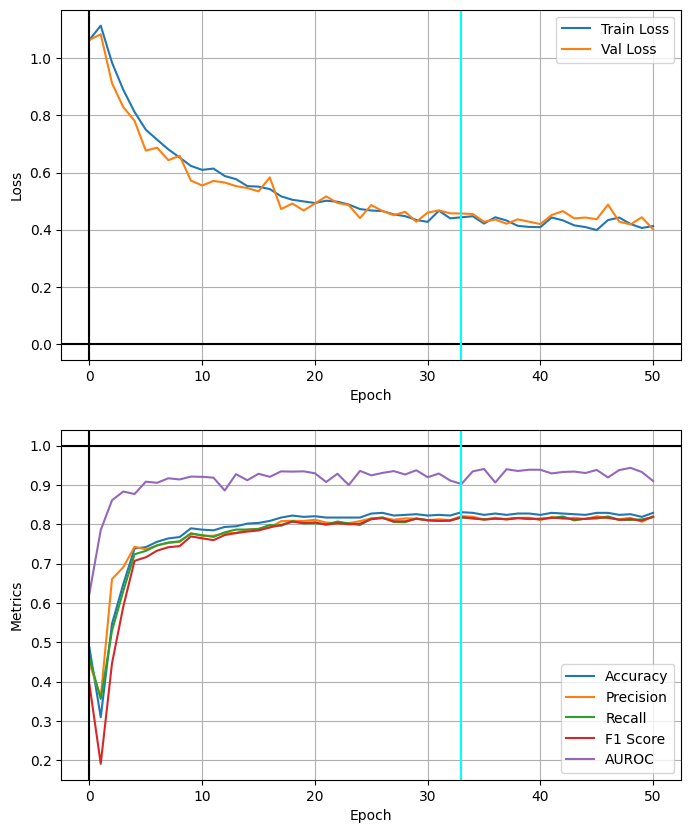

In [31]:
plt.figure(figsize=(8, 10))
plt.title(f'{model.__class__.__name__} Training/Validation Plot')
plt.axis('off')

# ========== (1) ==========

plt.subplot(2, 1, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
if len(train_losses) <= 20:
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.grid(True)
plt.axhline(0, color='black')
plt.axvline(0, color='black')
plt.axvline(best_acc_epoch, color='cyan')
plt.legend(loc='best')
# plt.ylim(-0.05, 1)

# ========== (2) ==========

plt.subplot(2, 1, 2)
plt.plot(accs, label='Accuracy')
plt.plot(precs, label='Precision')
plt.plot(recs, label='Recall')
plt.plot(f1s, label='F1 Score')
plt.plot(aurocs, label='AUROC')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
if len(train_losses) <= 20:
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.grid(True)
plt.axhline(1, color='black')
plt.axvline(0, color='black')
plt.axvline(best_acc_epoch, color='cyan')
plt.legend(loc='best')

plot_file_name = f'{unique_file_namer(model.__class__.__name__)}.png'
plt.savefig(os.path.join(plot_save_path, plot_file_name), bbox_inches='tight')

plt.show()

In [32]:
best_model_name = sorted(os.listdir(model_save_path))[-1]
best_model_path = os.path.join(model_save_path, best_model_name)
print(best_model_path)

model.load_state_dict(torch.load(best_model_path))

/kaggle/working/models/2024-05-31_02-27-26_PneumoniaDetector_50_1.00e-06_64.pth


<All keys matched successfully>

  0%|          | 0/19 [00:00<?, ?it/s]

Cross Entropy Loss: 0.4701 
Accuracy: 82.51% | Precision: 81.33% | Recall: 81.17% | F1 Score: 81.07% 
AUROC: 0.9281


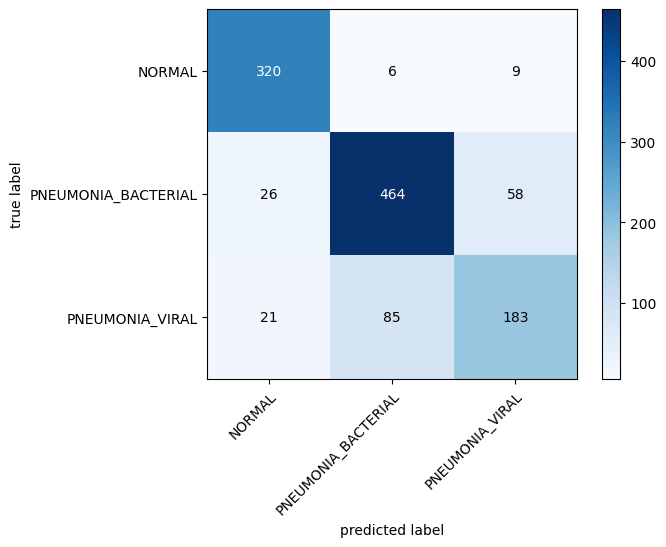

In [33]:
loss = 0
auroc = 0
master_confmat = torch.zeros(3, 3).to(device)

model.eval()
with torch.inference_mode():
    for X, y in tqdm(test_dataloader):
        X, y = X.to(device), y.to(device)
        logits = model(X)
        probs = logits.softmax(1)
        labels = probs.argmax(1)

        loss += criterion(logits, y).item()
        auroc += auroc_metric(probs, y).item()
        master_confmat += confmat_metric(labels, y)

loss /= len(test_dataloader)
auroc /= len(test_dataloader)
acc = confmat_to_accuracy(master_confmat)
prec = confmat_to_precision(master_confmat)
rec = confmat_to_recall(master_confmat)
f1 = confmat_to_f1score(master_confmat)

result = f'Cross Entropy Loss: {loss:.4f} \nAccuracy: {acc * 100:.2f}% | Precision: {prec * 100:.2f}% | Recall: {rec * 100:.2f}% | F1 Score: {f1 * 100:.2f}% \nAUROC: {auroc:.4f}'
print(result)

result_file_name = f'{unique_file_namer(model.__class__.__name__)}.txt'
with open(os.path.join(result_save_path, result_file_name), 'w') as f:
    f.write(result)

fig, ax = plot_confusion_matrix(
    conf_mat=master_confmat.cpu().numpy(),
    class_names=dataset.classes,
    colorbar=True
)

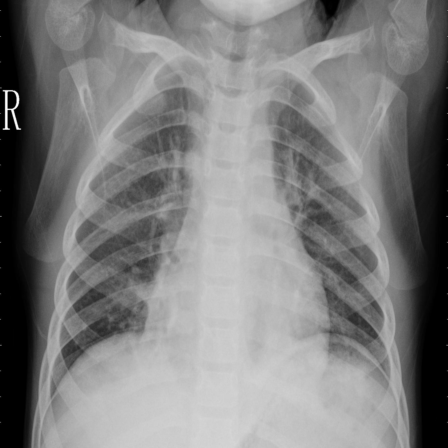

Raw Logits:                   tensor([-0.8042, -0.2095,  0.9656], device='cuda:0')
Prediction Probabilities:     tensor([0.1152, 0.2087, 0.6761], device='cuda:0')
Prediction Labels:            2

Prediction: PNEUMONIA_VIRAL
Target: PNEUMONIA_VIRAL


In [34]:
random_pred(test_dataset, model, classes=dataset.classes)